In [584]:
import re
import numpy as np
import numpy.random as npr
from scipy.stats import mode
from scipy.special import gammaln, digamma, logsumexp
from scipy.stats import dirichlet as dir
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

def clean_text(text):
    with open("vocab.txt", "r") as file:
        vocab = [line.strip() for line in file.readlines()]
    vocab_set = set(vocab)
    contractions = {
        r"n\'t": 'nt',
        r"\'s": 's',     
        r"\'ve": 've',   
        r"\'re": 're',   
        r"\'m": 'm',     
        r"\'ll": 'll',   
        r"\'d": 'd'      
    }

    text = text.lower().strip()
    text = re.sub(r'[.,!?;:"``]', " ", text)
    words = []
    for word in text.split():
        if "'" in word:
            word_added = False
            for pattern, replacement in contractions.items():
                if word.endswith(pattern):
                    contracted = word.replace(pattern, replacement)
                    if contracted in vocab_set:
                        words.append(contracted)
                        word_added = True
                        break
            if not word_added:
                combined = word.replace("'", "")
                if combined in vocab_set:
                    words.append(combined)
        if "-" in word:
            combined = word.replace("-", "")
            if combined in vocab_set:
                words.append(combined)
                continue 
            parts = [p for p in word.split("-") if p in vocab_set]
            words.extend(parts)
        else:
            if word in vocab_set:
                words.append(word)
    return words

rs = npr.RandomState(0)
K, V, N = 10, 300, 30
eta0, alpha0 = 0.8, 1 / K
Ms = rs.poisson(60, size=N)

In [628]:
def generate_lda(K, V, N, Ms, eta0=(100 / V), alpha0=(1 / K), rs_int=npr.randint(low=0, high=100)):
    rs = npr.RandomState(rs_int)
    beta = rs.dirichlet(np.full(V, eta0), size=K)
    theta = rs.dirichlet(np.full(K, alpha0), size=N)
    X = []
    for i in range(N):
        x_i = np.zeros(Ms[i], dtype=int)
        for j in range(Ms[i]):
            z_ij = rs.choice(K, p=theta[i])
            x_ij = rs.choice(V, p=beta[z_ij])
            x_i[j] = x_ij
        X.append(x_i)
    return X

def init_var_params(X, K, V, rs_int=npr.randint(low=0, high=100)):
    rs = npr.RandomState(rs_int)
    N = len(X)
    lambd = rs.uniform(low=0.5, high=1.0, size=(K, V))
    gamma = rs.uniform(low=0.1, high=1.0, size=(N, K))
    return np.log(lambd), np.log(gamma)

def sample_params(var_params):
    lambd, gamma = var_params
    log_gamm_beta = np.log(npr.gamma(np.exp(lambd), 1))
    log_probs_beta = log_gamm_beta - logsumexp(log_gamm_beta, axis=1)[:, None]
    beta = np.exp(log_probs_beta)

    log_gamm_gamma = np.log(npr.gamma(np.exp(gamma), 1))
    log_probs_gamma = log_gamm_gamma - logsumexp(log_gamm_gamma, axis=1)[:, None]
    theta = np.exp(log_probs_gamma)
    return beta, theta

def log_var_approx(var_params, latent_params):
    lambd, gamma = var_params
    beta, theta = latent_params
    K = lambd.shape[0]
    N = gamma.shape[0]

    log_q_beta = sum(dir.logpdf(beta[k], np.exp(lambd[k])) for k in range(K))
    log_q_theta = sum(dir.logpdf(theta[i], np.exp(gamma[i])) for i in range(N))
    return log_q_beta + log_q_theta

def log_joint_prob(latent_params, X):
    beta, theta = latent_params
    K = beta.shape[0]
    N = theta.shape[0]

    log_p_beta = sum(dir.logpdf(beta[k], np.full(beta[k].shape, eta0)) for k in range(K))
    log_p_theta = sum(dir.logpdf(theta[i], np.full(theta[i].shape, alpha0)) for i in range(N))
    # log_p_x = 0.0
    # for _, (theta_i, x_i) in enumerate(zip(theta, X)):
    #     beta_xi = beta[:, x_i]
    #     sum_word_probs = np.sum(np.log(theta_i[:, None] * beta_xi), axis=0)
    #     log_p_x += np.sum(sum_word_probs)
    log_p_x = 0.0
    for _, (theta_i, x_i) in enumerate(zip(theta, X)):
        beta_xi = beta[:, x_i]
        sum_word_probs = np.log(np.sum(theta_i[:, None] * beta_xi, axis=0))
        log_p_x += np.sum(sum_word_probs)
    return log_p_beta + log_p_theta + log_p_x

def score_dir(x, alpha):
    return digamma(np.sum(alpha)) - digamma(alpha) + np.log(x)

def score_var_dist(var_params, latent_params):
    lambd, gamma = var_params
    K = lambd.shape[0]
    N = gamma.shape[0]
    beta, theta = latent_params
    grad_lambd, grad_gamma = np.zeros_like(lambd), np.zeros_like(gamma)
    for k in range(K):
        grad_lambd[k] = score_dir(beta[k], np.exp(lambd[k]))
    for i in range(N):
        grad_gamma[i] = score_dir(theta[i], np.exp(gamma[i]))

    return grad_lambd, grad_gamma

def estimate_ELBO(var_params, S):
    lambd, gamma = var_params
    ELBO = 0.0
    for _ in range(S):
        beta_s, theta_s = sample_params((lambd, gamma))
        log_p = log_joint_prob((beta_s, theta_s), X)
        log_q = log_var_approx((lambd, gamma), (beta_s, theta_s))
        ELBO += (log_p - log_q)
    return ELBO / S

In [632]:
rs = npr.RandomState(0)
K, V, N = 10, 300, 30
eta0, alpha0 = 0.1, 5 / K
Ms = rs.poisson(60, size=N)
S = 20
eta = 1e-5
eps = 1e-8

X = generate_lda(K, V, N, Ms, eta0=eta0, alpha0=alpha0, rs_int=0)
lambd, gamma = init_var_params(X, K, V, 0)
G_lambd, G_gamma = np.zeros((V, V)), np.zeros((K, K))
max_iters = 10001
ELBOs = []

for t in range(max_iters):
    betas = []
    thetas = []
    for _ in range(S):
        beta_s, theta_s = sample_params((lambd, gamma))
        betas.append(beta_s)
        thetas.append(theta_s)

    stoch_score_grad_lambd = np.zeros_like(lambd)
    stoch_score_grad_gamma = np.zeros_like(gamma)
    for s in range(S):
        score_lambd, score_gamma = score_var_dist((lambd, gamma), (betas[s], thetas[s]))
        log_p = log_joint_prob((betas[s], thetas[s]), X)
        log_q = log_var_approx((lambd, gamma), (betas[s], thetas[s]))
        stoch_score_grad_lambd += score_lambd * (log_p - log_q)
        stoch_score_grad_gamma += score_gamma * (log_p - log_q)
    stoch_score_grad_lambd /= S
    stoch_score_grad_gamma /= S

    for k in range(K):
        G_lambd += np.outer(stoch_score_grad_lambd[k], stoch_score_grad_lambd[k])
    rho_lambd = eta * (G_lambd.diagonal() + eps)**(-0.5)

    for i in range(N):
        G_gamma += np.outer(stoch_score_grad_gamma[i], stoch_score_grad_gamma[i])
    rho_gamma = eta * (G_gamma.diagonal() + eps)**(-0.5)

    for k in range(K):
        lambd[k] += np.multiply(rho_lambd, stoch_score_grad_lambd[k])
    for i in range(N):
        gamma[i] += np.multiply(rho_gamma, stoch_score_grad_gamma[i])

    ELBO = estimate_ELBO((lambd, gamma), S)
    ELBOs.append(ELBO)
    if t % 100 == 0:
        print(f"Iteration {t}, ELBO: {ELBO}")

Iteration 0, ELBO: -13371.746023153708


Iteration 100, ELBO: -13370.931252622811
Iteration 200, ELBO: -13397.352084853559
Iteration 300, ELBO: -13392.726513972657
Iteration 400, ELBO: -13406.78992410707
Iteration 500, ELBO: -13367.911623432581
Iteration 600, ELBO: -13372.19465107983
Iteration 700, ELBO: -13371.494888839943
Iteration 800, ELBO: -13385.09060241537
Iteration 900, ELBO: -13398.092660074675
Iteration 1000, ELBO: -13349.880687024473
Iteration 1100, ELBO: -13382.313483717255
Iteration 1200, ELBO: -13385.789913591929
Iteration 1300, ELBO: -13391.745463063568
Iteration 1400, ELBO: -13393.486469392365
Iteration 1500, ELBO: -13383.2251638499
Iteration 1600, ELBO: -13413.518340372397
Iteration 1700, ELBO: -13381.45179990262
Iteration 1800, ELBO: -13385.477069685145
Iteration 1900, ELBO: -13387.109518098547
Iteration 2000, ELBO: -13360.521540952317
Iteration 2100, ELBO: -13406.335815308174
Iteration 2200, ELBO: -13356.32047709513
Iteration 2300, ELBO: -13376.231041313053
Iteration 2400, ELBO: -13368.501737154313
Iteratio

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10001,) and (4640,)

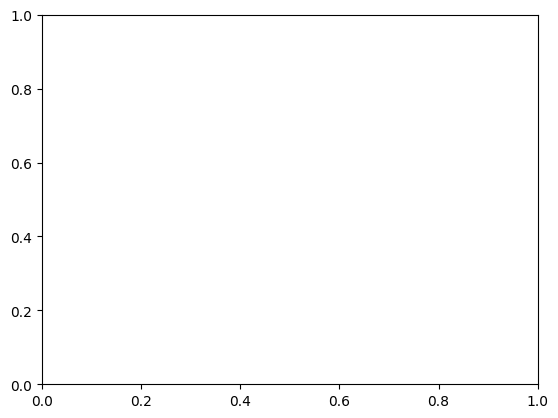

In [633]:
plt.plot(np.arange(max_iters), np.asarray(ELBOs))

In [586]:
rs = npr.RandomState(0)
K, V, N = 10, 300, 30
eta0, alpha0 = 0.1, 5 / K
Ms = rs.poisson(60, size=N)
X = generate_lda(K, V, N, Ms, eta0=eta0, alpha0=alpha0, rs_int=0)
lambd, gamma = init_var_params(X, K, V, 0)
beta, theta = sample_params((lambd, gamma))
log_joint_prob((beta, theta), X), log_var_approx((lambd, gamma), (beta, theta))

(np.float64(1570.6642264909242), np.float64(14972.673387488474))

In [ ]:
S = 10
rs = npr.RandomState(0)
K, V, N = 10, 300, 30
eta0, alpha0 = 0.1, 5 / K
Ms = rs.poisson(60, size=N)
eta = 0.00001
eps = 1e-8
X = generate_lda(K, V, N, Ms, eta0=0.01, alpha0=(5 / K), rs_int=0)
lambd, gamma = init_var_params(X, K, V, 0)
G_lambda = np.zeros((V, V))
G_gamma = np.zeros((K, K))

ELBOs = []
ELBO_init = 0.0
for s in range(S):
    beta_s, theta_s = sample_params((lambd, gamma))
    ELBO_init += log_joint_prob((beta_s, theta_s), X) - log_var_approx((lambd, gamma), (beta_s, theta_s))
print(f"Initial ELBO Estimate: {ELBO_init / S}")
ELBOs.append(ELBO_init)

for t in range(501):
    betas = []
    thetas = []
    grad_lambda = np.zeros_like(lambd)
    grad_gamma = np.zeros_like(gamma)
    for s in range(S):
        beta_s, theta_s = sample_params((lambd, gamma))
        grad_lambda_s, grad_gamma_s = stoch_score_grad((lambd, gamma), (beta_s, theta_s))
        log_p, log_q = log_joint_prob((beta_s, theta_s), X), log_var_approx((lambd, gamma), (beta_s, theta_s))

        grad_lambda += grad_lambda_s * (log_p - log_q)
        grad_gamma += grad_gamma_s * (log_p - log_q)
    grad_lambda /= S
    grad_gamma /= S

    for k in range(K):
        G_lambda += np.outer(grad_lambda[k], grad_lambda[k])
    rho_lambda = eta * (G_lambda.diagonal() + eps)**(-0.5)
    lambd += rho_lambda * grad_lambda
    for i in range(N):
        G_gamma += np.outer(grad_gamma[i], grad_gamma[i])
    rho_gamma = eta * (G_gamma.diagonal() + eps)**(-0.5)
    gamma += rho_gamma * grad_gamma

# G_lambda += grad_lambda * grad_lambda
# rho_lambda = eta * (G_lambda + eps)**(-0.5)
# lambd += rho_lambda * grad_lambda

# G_gamma += grad_gamma * grad_gamma
# rho_gamma = eta * (G_gamma + eps)**(-0.5)
# gamma += rho_gamma * grad_gamma

    ELBO_est = 0.0
    for s in range(S):
        beta_s, theta_s = sample_params((lambd, gamma))
        log_p = log_joint_prob((beta_s, theta_s), X)
        log_q = log_var_approx((lambd, gamma), (beta_s, theta_s))
        ELBO_est += (log_p - log_q)
    ELBOs.append(ELBO_est / S)
    if t % 50 == 0:
        print(f"Iteration {t} | ELBO Estimate: {ELBO_est / S}")

plt.plot(np.arange(0, len(ELBOs)), np.asarray(ELBOs))
# G_lambda += np.square(grad_lambda)
# G_gamma += np.square(grad_gamma)
# rho_lambda = rho / (np.sqrt(G_lambda) + eps)
# rho_gamma = rho / (np.sqrt(G_gamma) + eps)

# lambd += rho_lambda * grad_lambda
# gamma += rho_gamma * grad_gamma

Initial ELBO Estimate: -13376.625584388526
-13181.904574160842
Iteration 0 | ELBO Estimate: -13389.404297708383
-13445.026573833191
-13292.946747126987
-13351.389345770727
-13188.608268843358
-13456.190010973804
-13198.820038708509
-13424.245173566816
-13404.460417379092
-13495.621852282171
-13490.112914749947
-13313.931183301442
-13271.125307887405
-13271.29346346193
-13191.668112719972
-13297.197574788479
-13557.120451769324
-13600.95643203182
-13436.01762321374
-13200.859100119662
-13550.396084753658
-13536.579459945435
-13354.433381749463
-13272.921755892477
-13338.574291442399
-13502.813974590308
-13440.31950832073
-13600.237513304899
-13477.700522277048
-13310.118478619594
-13472.119654287359
-13433.232670427906
-13490.51084191163
-13321.864732287026
-13407.701566009027
-13487.397430774781
-13366.225209186236
-12986.440712734302
-13177.682188845987
-13414.010843302198
-13449.431501147841
-13461.181991411944
-13475.193451461015
-13208.757225930494
-13350.70935889908
-13386.4082458

KeyboardInterrupt: 

In [512]:
s = 0
log_joint_prob((latent_param_samples[0][s], latent_param_samples[1][s]), X)

ValueError: Parameter vector 'a' must be one dimensional, but a.shape = ().

In [482]:
mode(np.exp(lambd))[0], mode(np.exp(gamma))[0]

(array([0.2087412 , 0.22285342, 0.14564812, 0.11468519, 0.3267338 ,
        0.20175505, 0.16042344, 0.1047616 , 0.14141906, 0.19368743,
        0.1232136 , 0.13963517, 0.35248797, 0.17897851, 0.19773441,
        0.19807259, 0.14644993, 0.13598942, 0.17542377, 0.10784744,
        0.10679571, 0.1076479 , 0.2741715 , 0.36743574, 0.18058184,
        0.23407123, 0.12340706, 0.15683956, 0.18554181, 0.12700335,
        0.10848266, 0.18291311, 0.16392528, 0.29801047, 0.46521162,
        0.13164929, 0.23086096, 0.29104962, 0.20261528, 0.14653046,
        0.30480206, 0.1537737 , 0.15244529, 0.10997308, 0.14881359,
        0.18897767, 0.09994126, 0.29783775, 0.21301221, 0.13940431,
        0.13957767, 0.35623104, 0.11586672, 0.15009526, 0.11479504,
        0.12152344, 0.2813161 , 0.13433954, 0.22096539, 0.41937265,
        0.12459737, 0.17136021, 0.31145371, 0.11277909, 0.13046326,
        0.12221446, 0.13183677, 0.22212499, 0.29343044, 0.19509341,
        0.19963806, 0.1387936 , 0.14942507, 0.15

In [439]:
lambd, gamma = init_var_params(X, K, V)
beta, theta = sample_params((lambd, gamma))

K = beta.shape[0]
N = theta.shape[0]
log_p_beta = sum(dir.logpdf(beta[k], np.full(beta[k].shape, eta0)) for k in range(K))
log_p_theta = sum(dir.logpdf(theta[i], np.full(theta[i].shape, alpha0)) for i in range(N))

etas = np.ones(V) * eta0
gammaln(np.sum(etas)) - np.sum(gammaln(etas)) + np.sum((etas - 1) * np.log(beta[0]))

np.float64(1490.0376929100237)

In [448]:
log_joint_prob((beta, theta), X)

np.float64(3423.9505787750622)

In [449]:
log_p_x = 0.0
for i, (theta_i, x_i) in enumerate(zip(theta, X)):
    beta_xi = beta[:, x_i]
    sum_word_probs = np.sum(np.log(theta_i[:, None] * beta_xi), axis=0)
    log_p_x += np.sum(sum_word_probs)
log_p_x + log_p_beta + log_p_theta - log_var_approx((lambd, gamma), (beta, theta))

np.float64(-208753.6964655366)

In [483]:
with open("vocab.txt", "r") as file:
    vocab = [line.strip() for line in file.readlines()]
vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}
V = len(vocab_to_idx)
X = []

with open("ap.txt", "r") as file:
    raw_text = file.read()
documents = re.findall(r"<TEXT>\n(.*?)\n </TEXT", raw_text, re.DOTALL)
for doc in documents:
    words = clean_text(doc)
    if len(words) > 150:
        X.append([vocab_to_idx[word] for word in words])
X = [np.asarray(x_i) for x_i in X]
N = len(X)
Ms = [len(x_i) for x_i in X]
K = 20

In [486]:
S = 5
eta0, alpha0 = 0.1, 50 / K
eta, eps = 0.1, 1e-8
lambd, gamma = init_var_params(X, K, V)
G_lambda = np.zeros((K, V))
G_gamma = np.zeros((N, K))

for t in range(1000):
    grad_lambda = np.zeros_like(lambd)
    grad_gamma = np.zeros_like(gamma)
    for s in range(S):
        beta_s, theta_s = sample_params((lambd, gamma))
        grad_lambda_s, grad_gamma_s = stoch_score_grad((lambd, gamma), (beta_s, theta_s))
        log_p, log_q = log_joint_prob((beta_s, theta_s), X), log_var_approx((lambd, gamma), (beta_s, theta_s))
        grad_lambda += grad_lambda_s * (log_p - log_q)
        grad_gamma += grad_gamma_s * (log_p - log_q)
    grad_lambda /= S
    grad_gamma /= S

    G_lambda += grad_lambda * grad_lambda
    rho_lambda = eta * (G_lambda + eps)**(-0.5)
    lambd += rho_lambda * grad_lambda

    G_gamma += grad_gamma * grad_gamma
    rho_gamma = eta * (G_gamma + eps)**(-0.5)
    gamma += rho_gamma * grad_gamma

    if t % 10 == 0:
        print(f"Iteration: {t}")

Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Iteration: 110
Iteration: 120
Iteration: 130
Iteration: 140
Iteration: 150
Iteration: 160
Iteration: 170
Iteration: 180
Iteration: 190
Iteration: 200
Iteration: 210
Iteration: 220
Iteration: 230
Iteration: 240
Iteration: 250
Iteration: 260
Iteration: 270
Iteration: 280
Iteration: 290
Iteration: 300
Iteration: 310
Iteration: 320
Iteration: 330
Iteration: 340
Iteration: 350
Iteration: 360
Iteration: 370
Iteration: 380
Iteration: 390
Iteration: 400
Iteration: 410
Iteration: 420
Iteration: 430
Iteration: 440
Iteration: 450
Iteration: 460
Iteration: 470
Iteration: 480
Iteration: 490
Iteration: 500
Iteration: 510
Iteration: 520
Iteration: 530
Iteration: 540
Iteration: 550
Iteration: 560
Iteration: 570
Iteration: 580
Iteration: 590
Iteration: 600
Iteration: 610
Iteration: 620
Iteration: 630
Iteration: 640
Iteration: 650
Iteration: 660
Iterat

In [488]:
lambd_transf = np.exp(lambd)
word_topic_probs = lambd_transf / lambd_transf.sum(axis=1, keepdims=True)
top_words = {}
for k in range(word_topic_probs.shape[0]):
    top_idxs = np.argsort(word_topic_probs[k, :])[-15:][::-1]
    top_words[k] = [vocab[v] for v in top_idxs]

formatted_text = "Top 10 Words for Each Topic:\n\n"
for topic, words in top_words.items():
    formatted_text += f"Topic {topic + 1}: "
    formatted_text += ", ".join(words) + "\n\n"

print(formatted_text)

Top 10 Words for Each Topic:

Topic 1: horse, payment, exceeded, trucks, tour, damato, sake, hiv, aspirin, export, talk, liquidated, hoyt, butcher, mary

Topic 2: zieman, marching, belonging, agents, dominate, acid, reason, territorial, holiday, ultimately, rutah, evaluations, offended, unmanned, depardieu

Topic 3: whos, bust, mouth, dream, recommendation, referring, chuck, detector, plunge, bcspehealth, meal, persistent, centennial, tel, mens

Topic 4: delta, verify, blown, captain, israel, genuine, concluded, dyke, financial, avenue, rifle, tourism, calls, little, shows

Topic 5: edgemont, nablus, targets, efforts, nonprofit, greek, omaha, severely, lopez, strategies, archer, airbus, savings, payload, rear

Topic 6: explained, nun, performed, defect, furloughs, cubic, smiling, nationwide, booming, comedy, discussion, bloody, poorly, soybeans, likud

Topic 7: toys, forbidden, knight, naples, colonel, checking, yuri, louis, ratified, historians, rule, sikh, maryland, pac, perfume

Top